In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_20DLorenz.recursive_Markovian_PostMeanScore_20DLorenz_Stable_T256_H05_tl_110data_StbleTgt import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
num_paths = 1024 if config.feat_thresh == 1. else 10240
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
config = get_config()

In [15]:
def get_drift_files(config, root_dir ):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/20DLnz/"
    true_files = []
    local_files = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file and ((f"{config.forcing_const}FConst").replace(".","") in file):
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws

In [16]:
config = get_config()
true_files, local_files, bws = get_drift_files(config=config, root_dir=root_dir)
len(local_files)

21

nan 2.82e-05 inf


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_10025/430128308.py:13: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_10025/430128308.py:14: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


nan 3.72e-05 inf
nan 4.91e-05 inf
nan 6.49e-05 inf
nan 8.57e-05 inf
nan 0.0001131 inf
nan 0.0001493 inf
nan 0.0001972 inf
nan 0.0002603 inf
15.193591235310251 0.0073079 inf


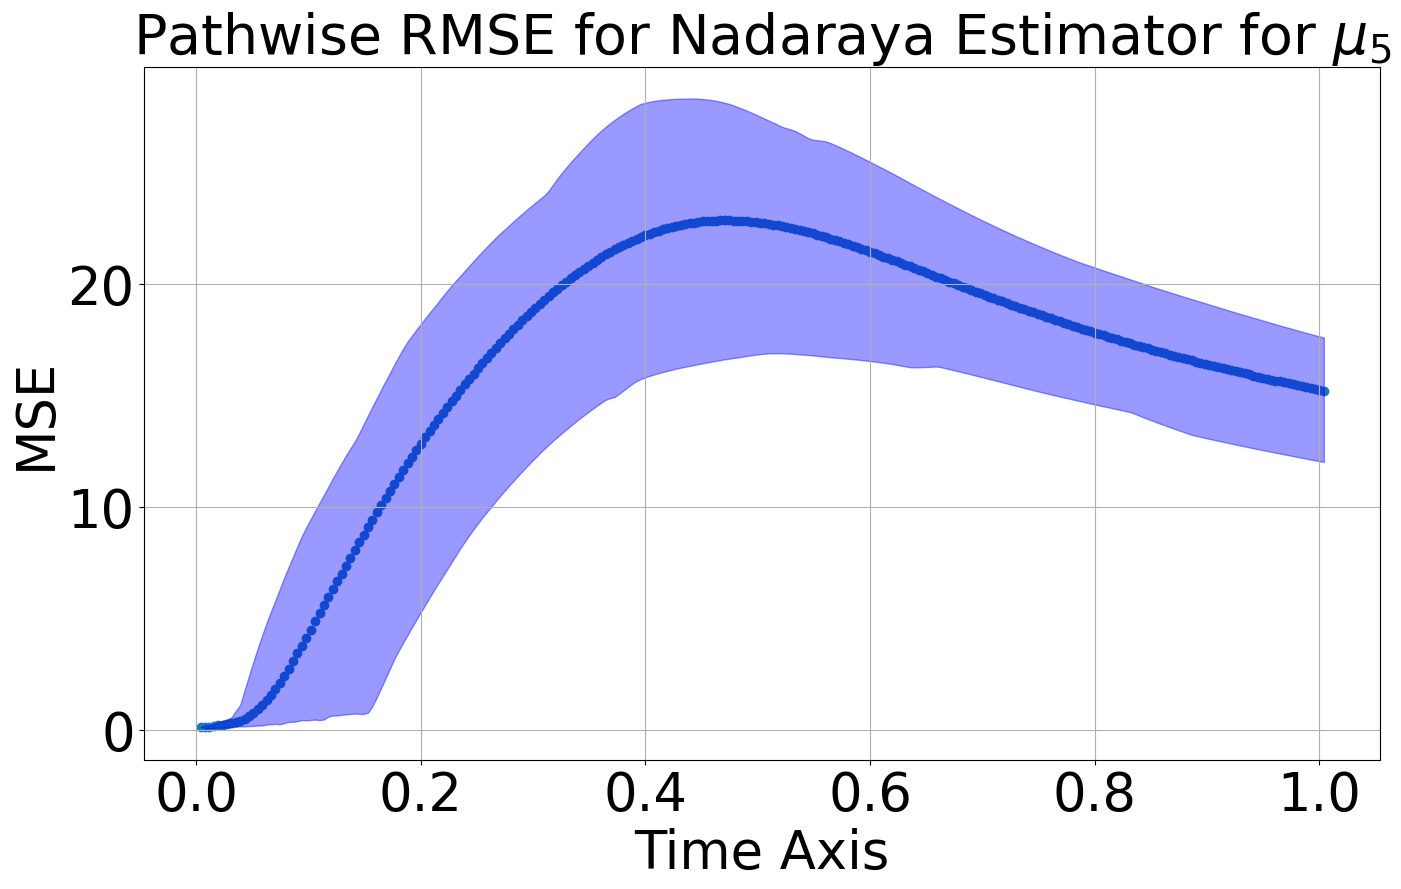

Final time cumulative MSE local-time error 15.193591235310251 with IQR ((12.010018629137114, 17.590205133310597))at bw 0.0073079 for 0.75FConst

14.715722001996804 0.009649 15.193591235310251


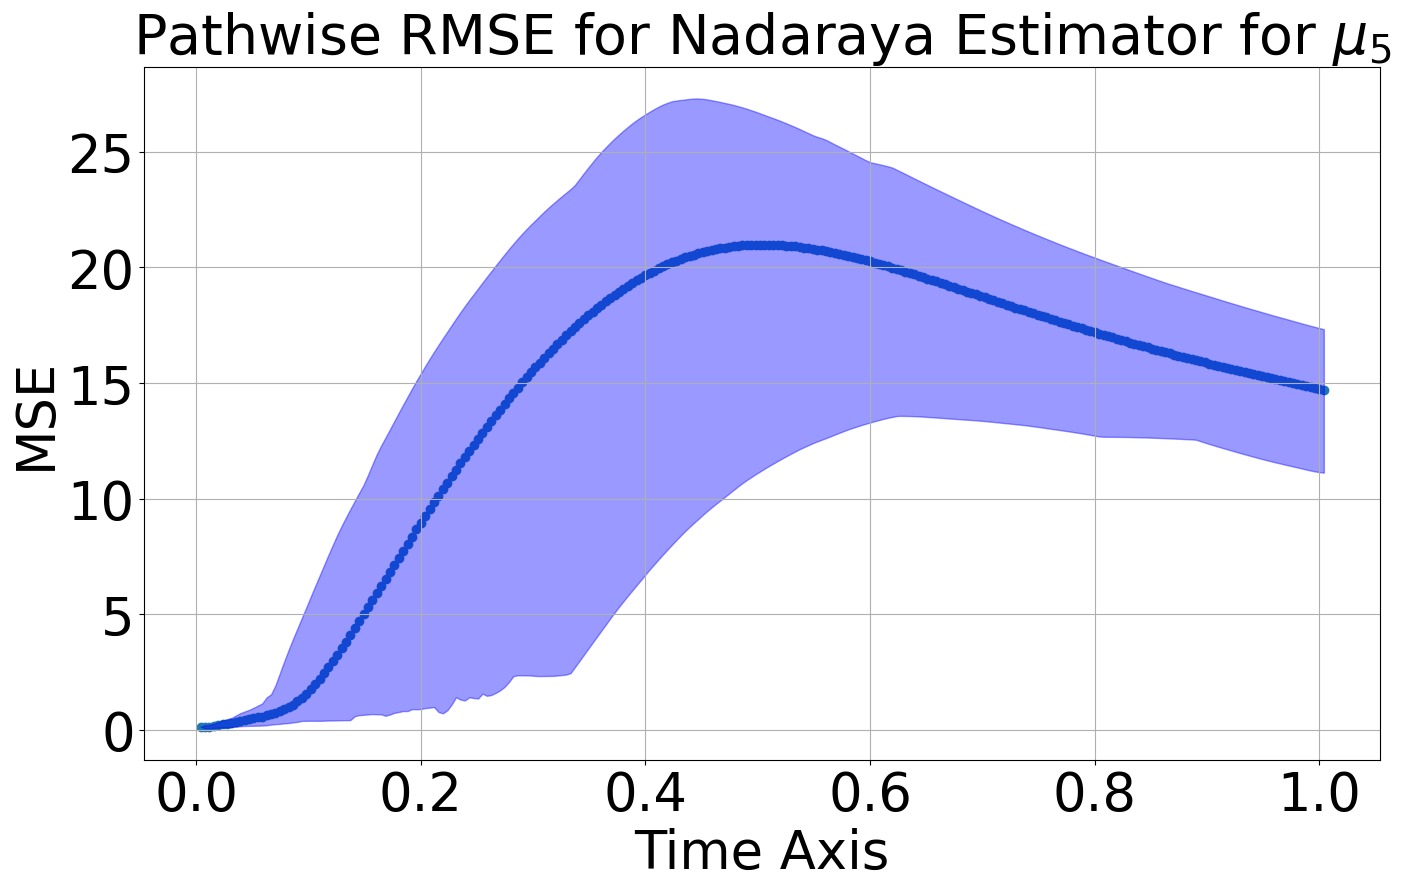

Final time cumulative MSE local-time error 14.715722001996804 with IQR ((11.120389669007414, 17.323755589775992))at bw 0.009649 for 0.75FConst

13.847906390967253 0.0127401 14.715722001996804


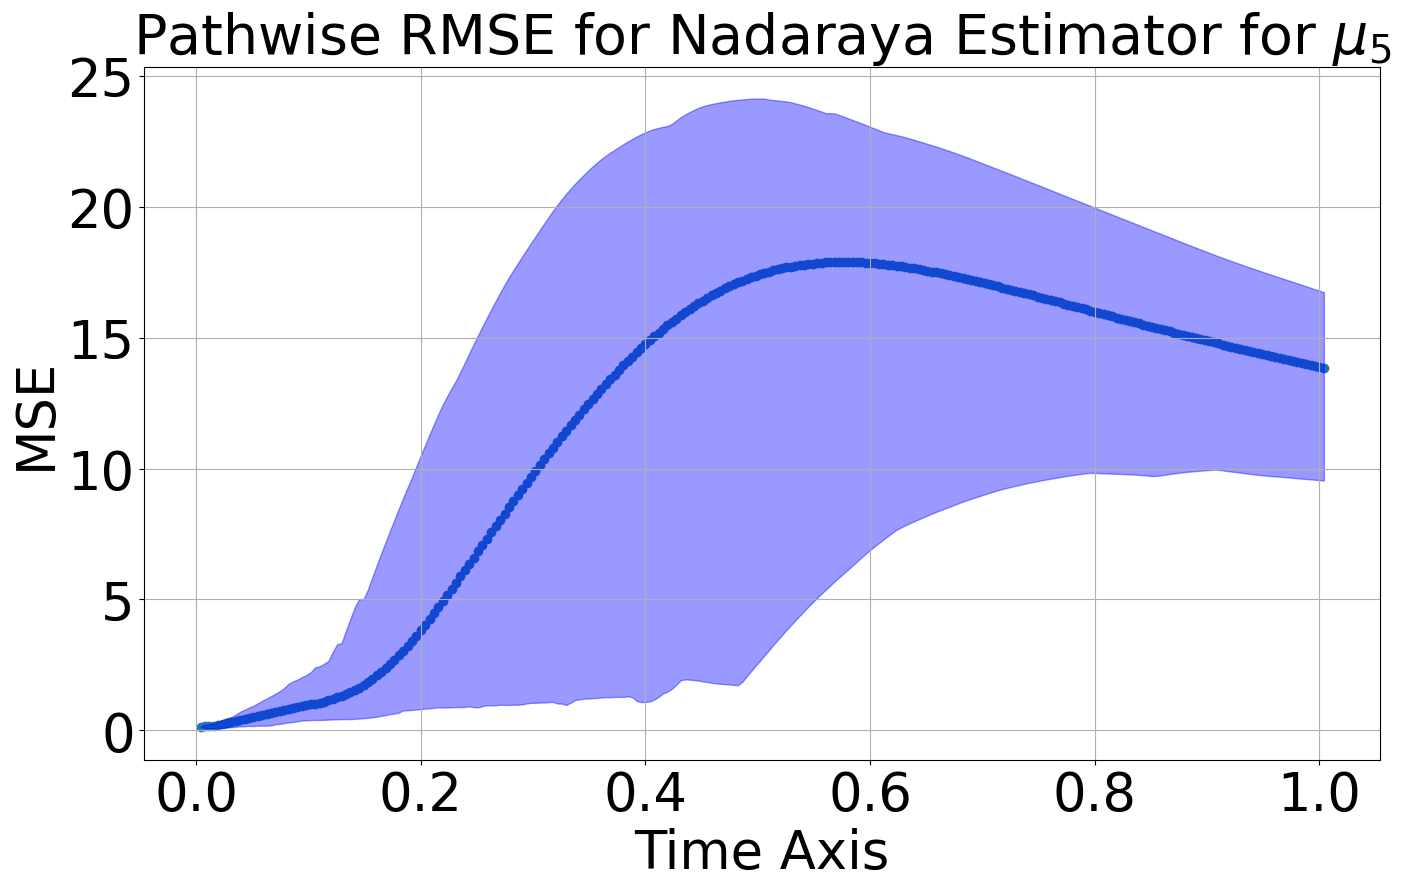

Final time cumulative MSE local-time error 13.847906390967253 with IQR ((9.543267213318494, 16.734566800771336))at bw 0.0127401 for 0.75FConst

11.407135915452049 0.0168214 13.847906390967253


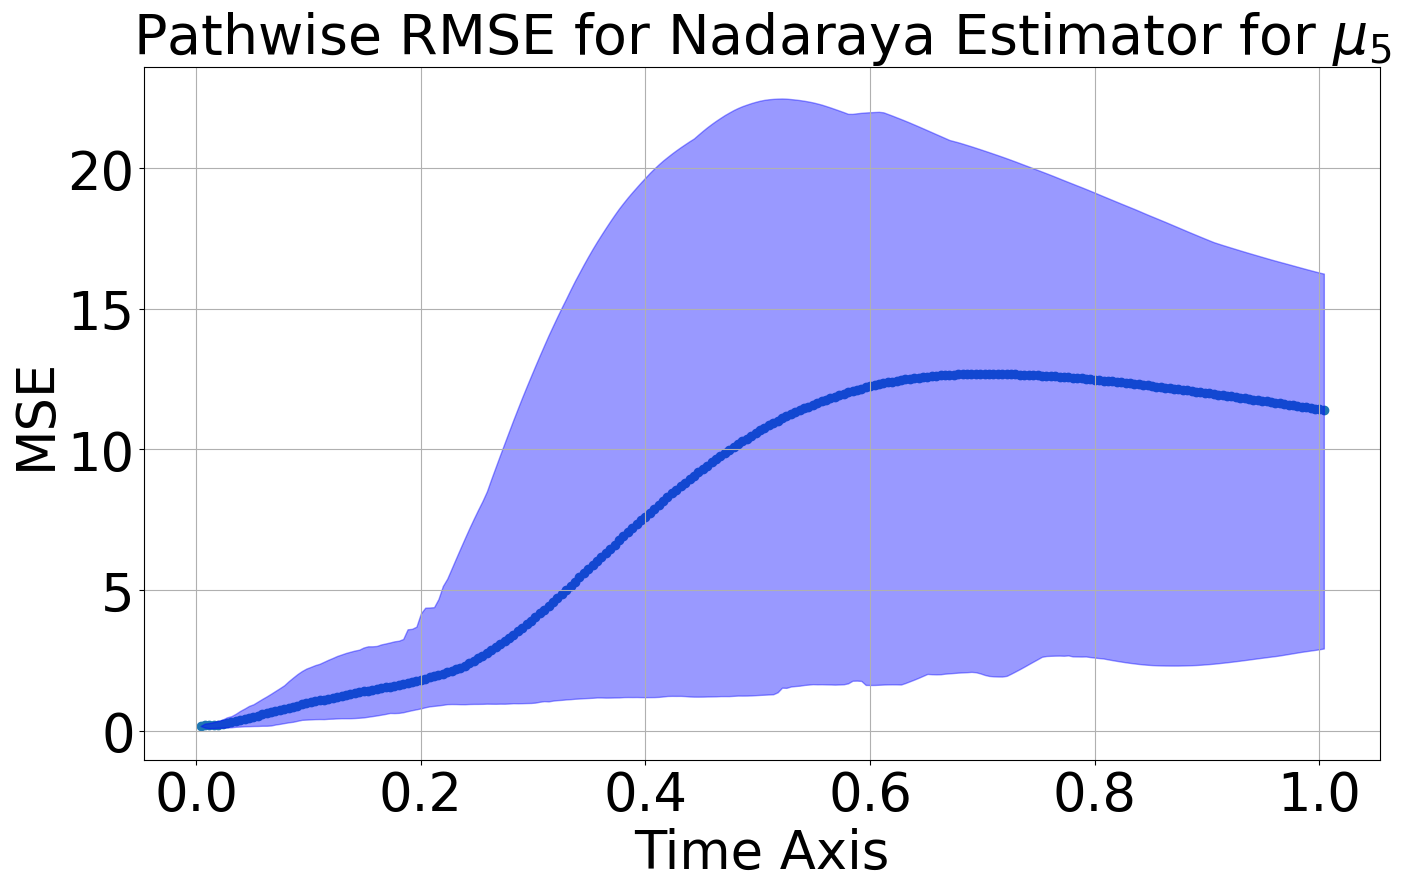

Final time cumulative MSE local-time error 11.407135915452049 with IQR ((2.9225813272036296, 16.251829240830727))at bw 0.0168214 for 0.75FConst

7.292258101606236 0.0222102 11.407135915452049


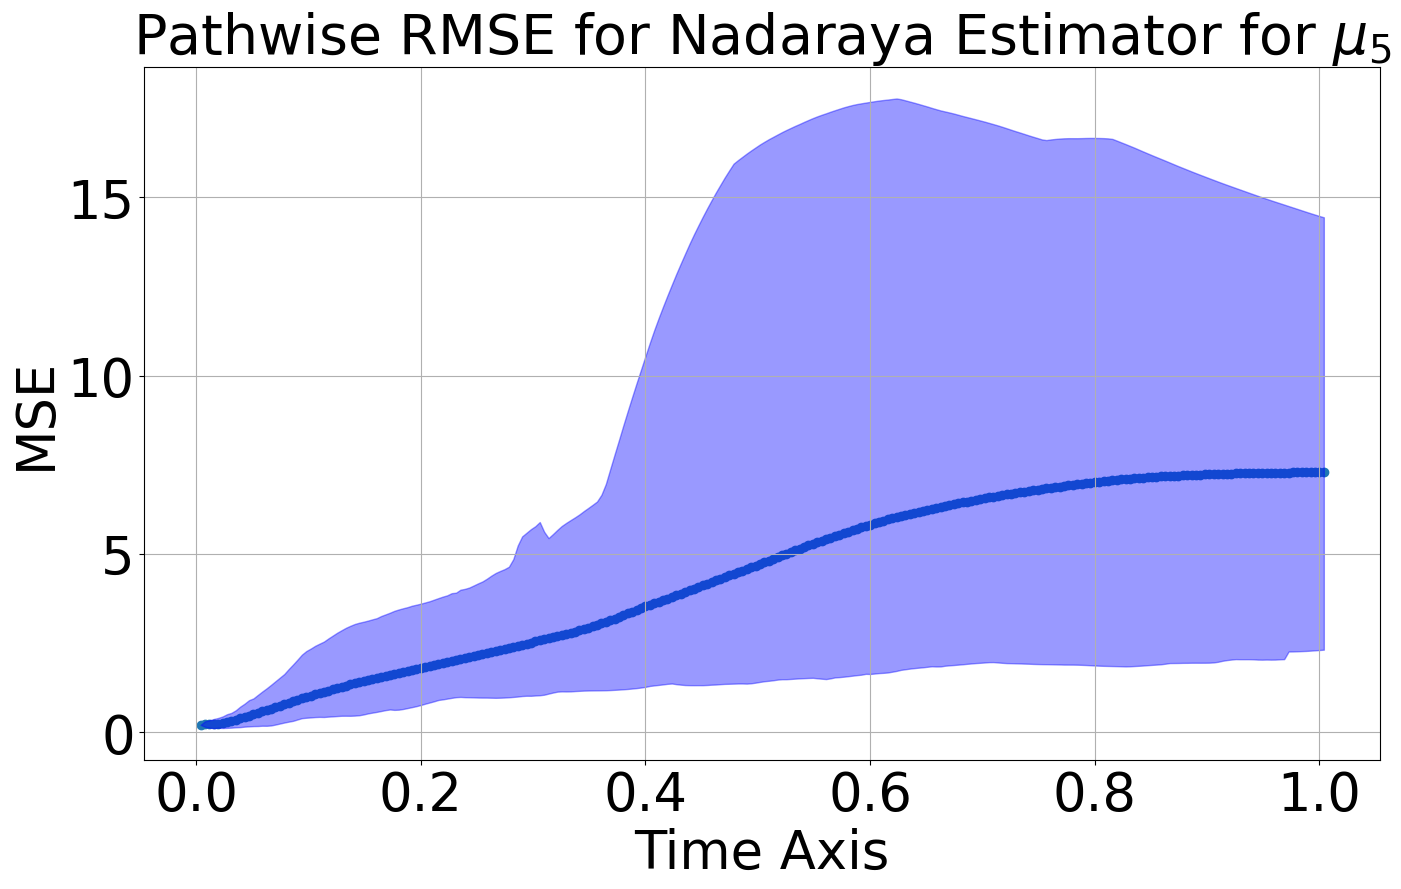

Final time cumulative MSE local-time error 7.292258101606236 with IQR ((2.3097579044234484, 14.439439251777811))at bw 0.0222102 for 0.75FConst

4.677849741622193 0.0293252 7.292258101606236


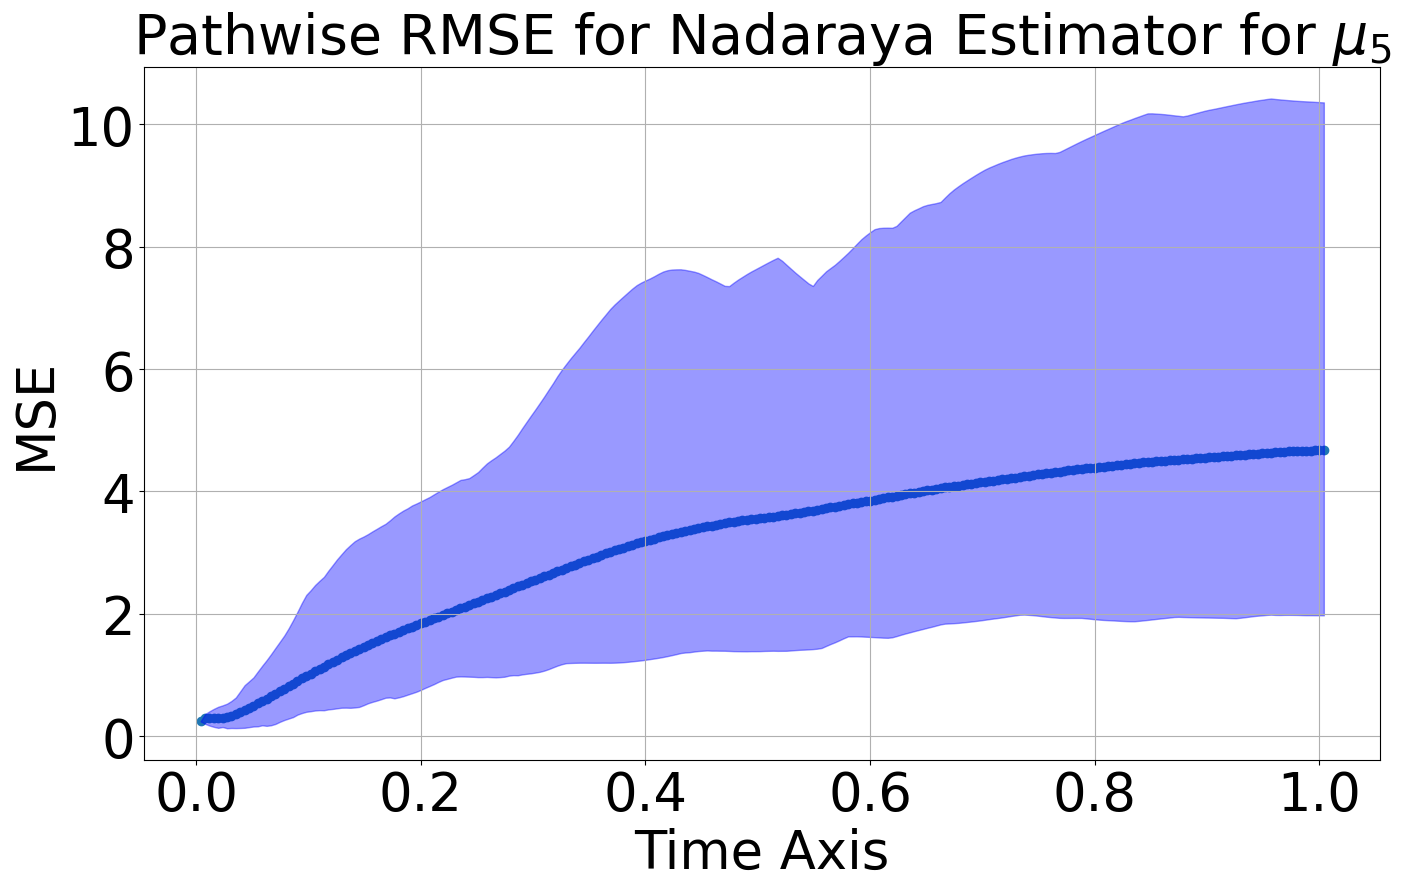

Final time cumulative MSE local-time error 4.677849741622193 with IQR ((1.9778062461618617, 10.354754363936916))at bw 0.0293252 for 0.75FConst

4.299398265516378 0.0387196 4.677849741622193


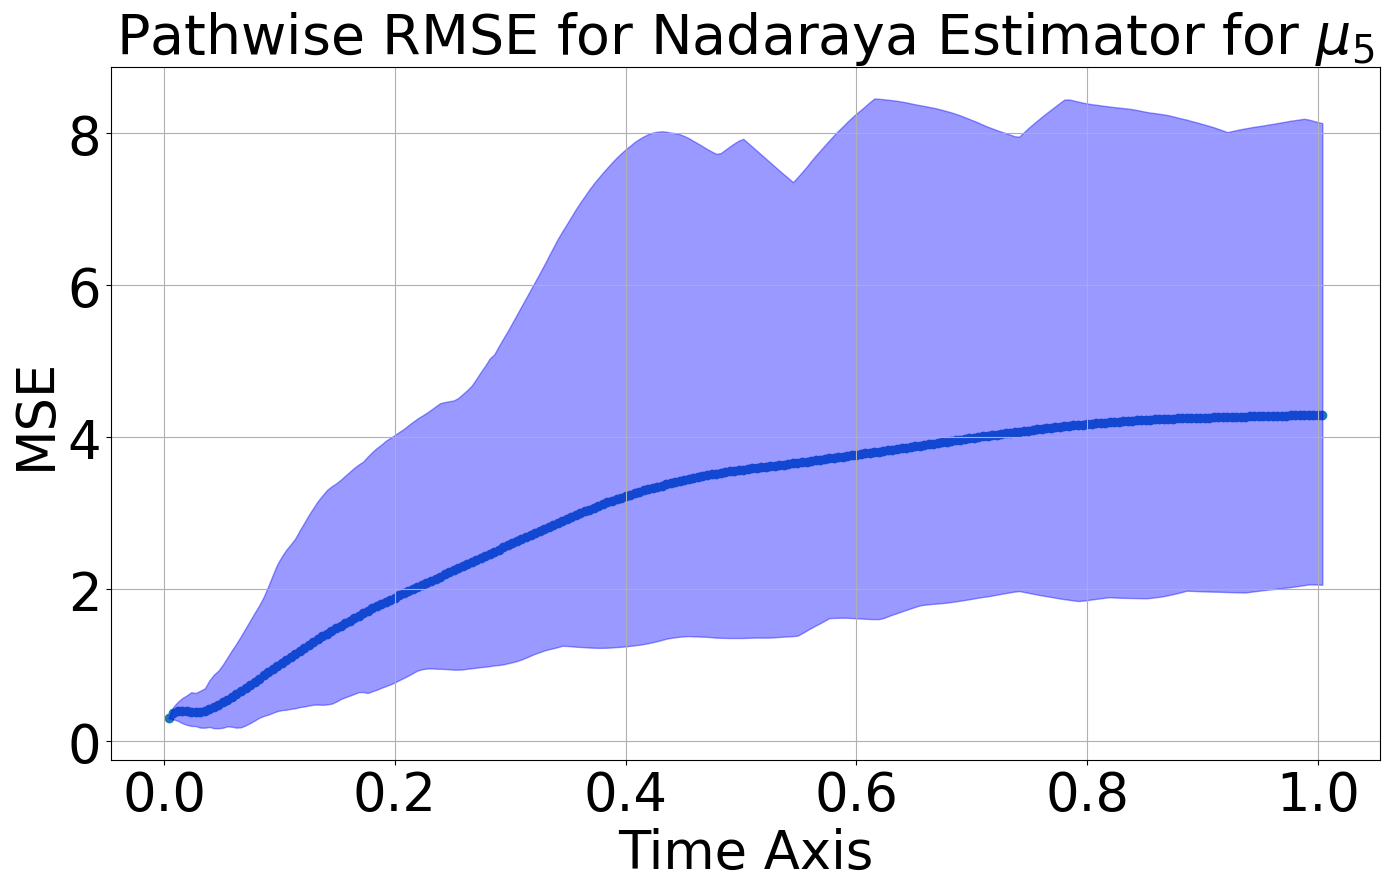

Final time cumulative MSE local-time error 4.299398265516378 with IQR ((2.061256115286992, 8.135438015838766))at bw 0.0387196 for 0.75FConst

4.273523498546777 0.0511235 4.299398265516378


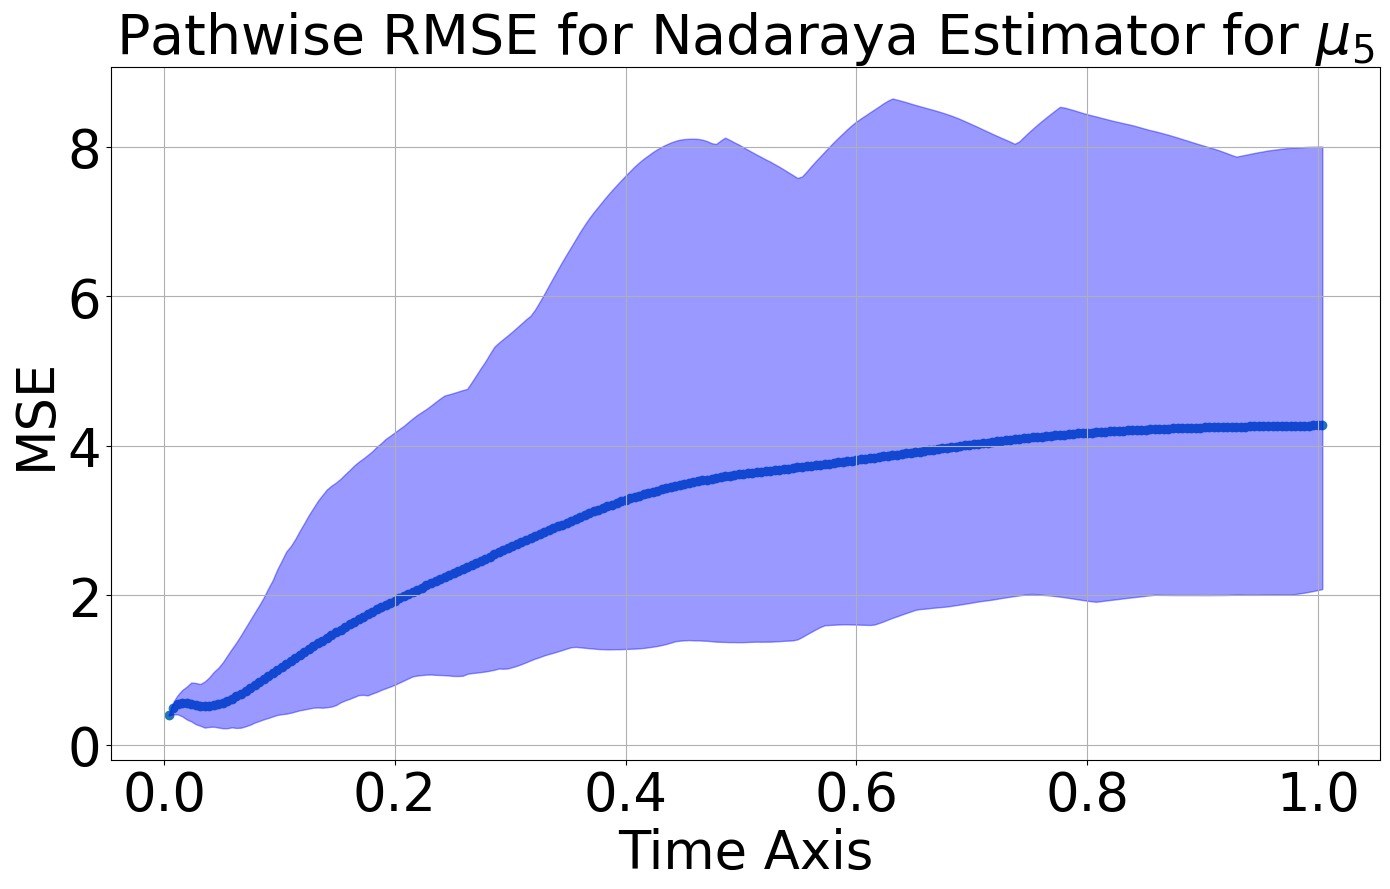

Final time cumulative MSE local-time error 4.273523498546777 with IQR ((2.0816564779637785, 8.002170257514855))at bw 0.0511235 for 0.75FConst

4.301864646834966 0.067501 4.273523498546777
4.350376260048662 0.0891251 4.273523498546777
4.403628776546203 0.1135011 4.273523498546777
4.466946781408864 0.144544 4.273523498546777


In [17]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0], allow_pickle=True)
    all_local_states = np.load(file[1], allow_pickle=True)
    if all_local_states.shape[0] != 2: continue
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)
        print(total_local_errors[-1], bw, curr_rmse)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Nadaraya Estimator for $\mu_5$",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                print(root_dir + f"DiffusionModelPresentationImages/")
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya/20DLnz/IIDNadaraya_{config.ndims}DLnz_DriftTrack_{round(bw, 6)}bw_{config.forcing_const}FConst_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw} for {config.forcing_const}FConst\n")

In [18]:
from utils.resource_logger import wallclock_and_system_metrics
data = wallclock_and_system_metrics(config.nadaraya_resource_logging_path, inclusive=False)
data

{'progress_name': 'idx',
 'span_units': 2.0,
 'wall_clock_h_total': 16.214603246649105,
 'wall_clock_per_unit_h': 8.107301623324553,
 'cpu_avg_pct': 33.76981519507186,
 'cpu_peak_pct': 63.2,
 'ram_avg_gib': 176.00296937166323,
 'ram_peak_gib': 233.773332,
 'gpu_util_avg_pct': None,
 'gpu_util_peak_pct': None,
 'gpu_mem_avg_gib': None,
 'gpu_mem_peak_gib': None}